In [87]:
# Load Twitter dataset (from Kaggle)
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("thedevastator/tweets-and-user-engagement")

print("Path to dataset files:", path)
# source: https://www.kaggle.com/datasets/thedevastator/tweets-and-user-engagement

file_path = '/root/.cache/kagglehub/datasets/thedevastator/tweets-and-user-engagement/versions/2/Twitterdatainsheets.csv'
df_twitter = pd.read_csv(file_path)

df_twitter.columns = df_twitter.columns.str.strip()
weekday_col = 'Weekday'
hour_col = 'Hour'
day_col = 'Day'
month_col = 'Month'

print(df_twitter.columns)

Path to dataset files: /kaggle/input/tweets-and-user-engagement
Index(['index', 'TweetID', 'Weekday', 'Hour', 'Day', 'Lang', 'IsReshare',
       'Reach', 'RetweetCount', 'Likes', 'Klout', 'Sentiment', 'text',
       'LocationID', 'UserID'],
      dtype='object')


<ipython-input-87-ee504f83b9df>:12: DtypeWarning: Columns (3,4,5,6,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_twitter = pd.read_csv(file_path)


In [88]:
# Map weekday names to numbers (Monday=0, Sunday=6)
weekday_map = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df_twitter[day_col] = pd.to_numeric(df_twitter[day_col], errors='coerce')
df_twitter.dropna(subset=[day_col], inplace=True)
df_twitter[day_col] = df_twitter[day_col].astype(int)
df_twitter[hour_col] = df_twitter[hour_col].astype(int)

n = len(df_twitter)

jan_end_idx = int(n * (31/92))   # Jan 31 is day 31 out of 92 days total
feb_end_idx = int(n * (59/92))   # Feb 28 is day 59
mar_end_idx = int(n * (90/92))   # Mar 31 is day 90

df_twitter['Month'] = 0

# df_twitter = df_twitter.reset_index(drop=True)  # reset index to ensure iloc works correctly

df_twitter.iloc[:jan_end_idx, df_twitter.columns.get_loc('Month')] = 1
df_twitter.iloc[jan_end_idx:feb_end_idx, df_twitter.columns.get_loc('Month')] = 2
df_twitter.iloc[feb_end_idx:mar_end_idx, df_twitter.columns.get_loc('Month')] = 3
df_twitter.iloc[mar_end_idx:, df_twitter.columns.get_loc('Month')] = 4

print(df_twitter['Month'].value_counts().sort_index())

# data is from beginning of 2016 to april 2016 only
year = 2016

days_in_month = {1: 31, 2: 29, 3: 31, 4: 30}

df_twitter = df_twitter[
    df_twitter.apply(lambda row: row[day_col] <= days_in_month.get(row['Month'], 0), axis=1)
].copy()

# df_twitter = df_twitter[df_twitter[day_col] <= 30].copy()

df_twitter['timestamp'] = pd.to_datetime({'year': year, 'month': df_twitter['Month'].astype(int), 'day': df_twitter[day_col], 'hour': df_twitter[hour_col]})
df_twitter['date'] = df_twitter['timestamp'].dt.date
df_twitter = df_twitter.dropna(subset=['timestamp'])

df_twitter['timestamp'] = pd.to_datetime(df_twitter['timestamp'], errors='coerce', utc=True)
df_twitter = df_twitter.sort_values('timestamp')

df_twitter['date'] = df_twitter['timestamp'].dt.date

print(df_twitter[['timestamp', 'date']].head())

# print(df_twitter.head())

Month
1    33695
2    30435
3    33696
4     2174
Name: count, dtype: int64
                      timestamp        date
29408 2016-01-01 00:00:00+00:00  2016-01-01
97    2016-01-01 00:00:00+00:00  2016-01-01
98    2016-01-01 00:00:00+00:00  2016-01-01
99    2016-01-01 00:00:00+00:00  2016-01-01
100   2016-01-01 00:00:00+00:00  2016-01-01


In [89]:
start_date = df_twitter['date'].min()
end_date = df_twitter['date'].max()

print(f"Twitter dataset covers from {start_date} to {end_date}")

Twitter dataset covers from 2016-01-01 to 2016-04-02


In [ ]:
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Load and prepare data with additional features
nasdaq = yf.download('^IXIC', start='2016-01-01', end='2016-04-30', interval='1d')
data = nasdaq[['Close', 'Volume']].copy()

# Compute features
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['RSI'] = 100 - (100 / (1 + (data['Close'].diff().rolling(window=14).mean() / (data['Close'].diff().rolling(window=14).std() + 1e-10))))
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()
data['Volatility'] = data['Close'].pct_change().rolling(window=14).std()  # 14-day volatility
data['Lag1_Return'] = data['Close'].pct_change().shift(1)  # Lagged return (1 day)
data['Next_Day_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)

print(data.head(10))
print("\nShape Train Data")

[*********************100%***********************]  1 of 1 completed

Price             Close      Volume         MA_5 MA_20 RSI           OBV  \
Ticker            ^IXIC       ^IXIC                                        
Date                                                                       
2016-01-04  4903.089844  2218420000          NaN   NaN NaN           NaN   
2016-01-05  4891.430176  1927380000          NaN   NaN NaN -1.927380e+09   
2016-01-06  4835.759766  2168620000          NaN   NaN NaN -4.096000e+09   
2016-01-07  4689.430176  2552590000          NaN   NaN NaN -6.648590e+09   
2016-01-08  4643.629883  2288750000  4792.667969   NaN NaN -8.937340e+09   
2016-01-11  4637.990234  2391110000  4739.648047   NaN NaN -1.132845e+10   
2016-01-12  4685.919922  2147470000  4698.545996   NaN NaN -9.180980e+09   
2016-01-13  4526.060059  2533200000  4636.606055   NaN NaN -1.171418e+10   
2016-01-14  4615.000000  2565560000  4621.720020   NaN NaN -9.148620e+09   
2016-01-15  4488.419922  2818630000  4590.678027   NaN NaN -1.196725e+10   

Price      

In [101]:
# Flatten MultiIndex columns if they exist
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

data = data.rename(columns={'Date': 'date'})
data['date'] = pd.to_datetime(data['date'])

df_twitter['date'] = pd.to_datetime(df_twitter['date'])

print(data.columns)

merged_df = pd.merge(data, df_twitter, on='date', how='inner')

print(data.columns)
print(merged_df.head())

Index(['level_0', 'index', 'date', 'Close_^IXIC', 'Volume_^IXIC', 'MA_5',
       'MA_20', 'RSI', 'OBV', 'Volatility', 'Lag1_Return', 'Next_Day_Up'],
      dtype='object')
Index(['level_0', 'index', 'date', 'Close_^IXIC', 'Volume_^IXIC', 'MA_5',
       'MA_20', 'RSI', 'OBV', 'Volatility', 'Lag1_Return', 'Next_Day_Up'],
      dtype='object')
   level_0  index_x       date  Close_^IXIC  Volume_^IXIC  MA_5  MA_20  RSI  \
0        0        0 2016-01-04  4903.089844    2218420000   NaN    NaN  NaN   
1        0        0 2016-01-04  4903.089844    2218420000   NaN    NaN  NaN   
2        0        0 2016-01-04  4903.089844    2218420000   NaN    NaN  NaN   
3        0        0 2016-01-04  4903.089844    2218420000   NaN    NaN  NaN   
4        0        0 2016-01-04  4903.089844    2218420000   NaN    NaN  NaN   

   OBV  Volatility  ...  Reach  RetweetCount  Likes Klout Sentiment  \
0  NaN         NaN  ...  528.0           0.0    0.0  43.0       1.5   
1  NaN         NaN  ...   21.0          6

In [107]:
print(merged_df.columns)

merged_df = merged_df.dropna()

# Features and target
X = merged_df[['Sentiment']].values
y = merged_df['Next_Day_Up'].values # the next day NASDAQ prices (to compare with yesterday's tweets)

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

Index(['level_0', 'index_x', 'date', 'Close_^IXIC', 'Volume_^IXIC', 'MA_5',
       'MA_20', 'RSI', 'OBV', 'Volatility', 'Lag1_Return', 'Next_Day_Up',
       'index_y', 'TweetID', 'Weekday', 'Hour', 'Day', 'Lang', 'IsReshare',
       'Reach', 'RetweetCount', 'Likes', 'Klout', 'Sentiment', 'text',
       'LocationID', 'UserID', 'Month', 'timestamp'],
      dtype='object')


In [111]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7]}
grid_knn = GridSearchCV(knn, param_grid, scoring='f1', cv=5)
grid_knn.fit(X_train_scaled, y_train)

y_pred = grid_knn.predict(X_test_scaled)
print("KNN Classification Report (NASDAQ via Twitter Sentiment):")
print(classification_report(y_test, y_pred, target_names=['Up', 'Down']))


KNN Classification Report (NASDAQ via Twitter Sentiment):
              precision    recall  f1-score   support

          Up       0.37      0.01      0.01      5130
        Down       0.68      0.99      0.81     10919

    accuracy                           0.68     16049
   macro avg       0.53      0.50      0.41     16049
weighted avg       0.58      0.68      0.55     16049



In [ ]:
# GMM Classifier
def multivariate_gaussian(x, mean, cov):
    d = x.shape[1]
    cov_inv = np.linalg.inv(cov + 1e-6 * np.eye(d))  # Add small value to diagonal for stability
    diff = x - mean
    exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    norm_factor = np.sqrt((2 * np.pi)**d * np.linalg.det(cov + 1e-6 * np.eye(d)))
    return exp_term / norm_factor


class GMMClassifier:
    def __init__(self, max_iter=10):
        self.max_iter = max_iter

    def fit(self, X, y):
        n_samples = X.shape[0]
        labels = np.zeros(n_samples, dtype=int)
        labels[:n_samples//2] = 0
        labels[n_samples//2:] = 1
        rho = 0.5

        for _ in range(self.max_iter):
            self.mu0 = np.mean(X[labels == 0], axis=0, keepdims=True)
            self.mu1 = np.mean(X[labels == 1], axis=0, keepdims=True)
            self.sigma0 = np.cov(X[labels == 0].T)
            self.sigma1 = np.cov(X[labels == 1].T)

            likelihood0 = multivariate_gaussian(X, self.mu0, self.sigma0)
            likelihood1 = multivariate_gaussian(X, self.mu1, self.sigma1)

            gamma0 = likelihood0 * rho
            gamma1 = likelihood1 * (1 - rho)
            total_gamma = gamma0 + gamma1
            gamma0 /= total_gamma + 1e-10
            gamma1 /= total_gamma + 1e-10

            labels = np.where(gamma0 > gamma1, 0, 1)
            N0 = np.sum(gamma0)
            N1 = np.sum(gamma1)
            rho = N0 / n_samples

        self.rho = rho


    def predict(self, X):
        likelihood0 = multivariate_gaussian(X, self.mu0, self.sigma0)
        likelihood1 = multivariate_gaussian(X, self.mu1, self.sigma1)
        posterior0 = likelihood0 * self.rho
        posterior1 = likelihood1 * (1 - self.rho)
        return np.where(posterior0 > posterior1, 0, 1)

gmm = GMMClassifier(max_iter=10)
gmm.fit(X_train_scaled, y_train)
y_pred_gmm = gmm.predict(X_test_scaled)

cm_gmm = confusion_matrix(y_test, y_pred_gmm)
accuracy_gmm = accuracy_score(y_test, y_pred_gmm)
precision_gmm = precision_score(y_test, y_pred_gmm, zero_division=0)
recall_gmm = recall_score(y_test, y_pred_gmm, zero_division=0)
f1_gmm = f1_score(y_test, y_pred_gmm, zero_division=0)


print("GMM Classifier Report:")
print(classification_report(y_test, y_pred_gmm, target_names=['Up', 'Down']))


print("GMM Results:")
print("Confusion Matrix:")
print(cm_gmm)
print(f"Accuracy: {accuracy_gmm:.4f}")
print(f"Precision: {precision_gmm:.4f}")
print(f"Recall: {recall_gmm:.4f}")
print(f"F1-Score: {f1_gmm:.4f}\n")

GMM Classifier Report:
              precision    recall  f1-score   support

          Up       0.33      0.69      0.44      5130
        Down       0.70      0.34      0.46     10919

    accuracy                           0.45     16049
   macro avg       0.51      0.51      0.45     16049
weighted avg       0.58      0.45      0.45     16049

GMM Results:
Confusion Matrix:
[[3518 1612]
 [7185 3734]]
Accuracy: 0.4519
Precision: 0.6985
Recall: 0.3420
F1-Score: 0.4591



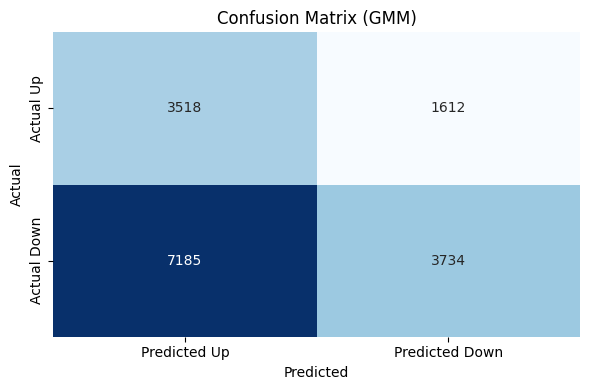

In [113]:
# Visualize Confusion Matrix for GMM
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Up', 'Predicted Down'],
            yticklabels=['Actual Up', 'Actual Down'])
plt.title("Confusion Matrix (GMM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('confusion_matrix_nasdaq_GMM.png')
plt.show()

In [ ]:
# KNN Classifier with Tuning
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn = KNeighborsClassifier(weights='distance')
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

cm_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, zero_division=0)

print("KNN Results (Best k =", grid_search_knn.best_params_['n_neighbors'], "):")
print("Confusion Matrix:")
print(cm_knn)
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-Score: {f1_knn:.4f}\n")

knn = KNeighborsClassifier(weights='distance')
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(knn, param_grid, scoring='f1', cv=5)
grid_knn.fit(X_train_scaled, y_train)
y_pred_knn = grid_knn.predict(X_test_scaled)

print(f"KNN (best k={grid_knn.best_params_['n_neighbors']}) Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Up', 'Down']))

KNN Results (Best k = 9 ):
Confusion Matrix:
[[   38  5092]
 [   57 10862]]
Accuracy: 0.6792
Precision: 0.6808
Recall: 0.9948
F1-Score: 0.8084

KNN (best k=9) Report:
              precision    recall  f1-score   support

          Up       0.40      0.01      0.01      5130
        Down       0.68      0.99      0.81     10919

    accuracy                           0.68     16049
   macro avg       0.54      0.50      0.41     16049
weighted avg       0.59      0.68      0.55     16049



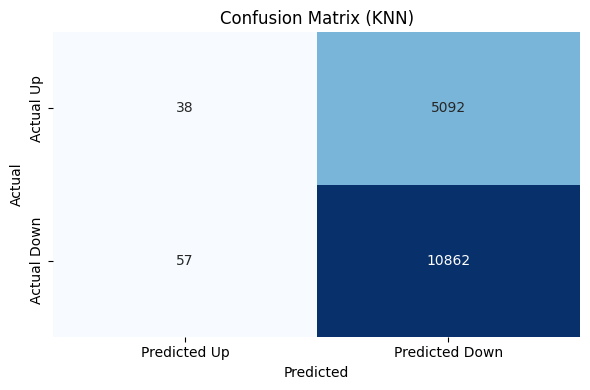

In [119]:
# Visualize Confusion Matrix for KNN
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Up', 'Predicted Down'],
            yticklabels=['Actual Up', 'Actual Down'])
plt.title("Confusion Matrix (KNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('confusion_matrix_nasdaq_KNN.png')
plt.show()

In [ ]:
# Improved Neural Network
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s) + 1e-9

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output, class_weights):
        m = X.shape[0]
        y = y.reshape(-1, 1)
        sample_weights = np.array([class_weights[int(label)] for label in y.flatten()]).reshape(-1, 1)

        self.error = (output - y) * sample_weights
        self.d_output = self.error * sigmoid_derivative(self.z2)
        self.error_hidden = np.dot(self.d_output, self.W2.T)
        self.d_hidden = self.error_hidden * relu_derivative(self.z1)

        self.W2 -= self.learning_rate * np.dot(self.a1.T, self.d_output) / m
        self.b2 -= self.learning_rate * np.sum(self.d_output, axis=0, keepdims=True) / m
        self.W1 -= self.learning_rate * np.dot(X.T, self.d_hidden) / m
        self.b1 -= self.learning_rate * np.sum(self.d_hidden, axis=0, keepdims=True) / m

    def train(self, X, y, epochs, class_weights):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output, class_weights)
            sample_weights = np.array([class_weights[int(label)] for label in y.flatten()]).reshape(-1, 1)
            loss = -np.mean(sample_weights * (y.reshape(-1, 1) * np.log(output + 1e-9) +
                                              (1 - y.reshape(-1, 1)) * np.log(1 - output + 1e-9)))
            if (epoch + 1) % 500 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

# Train Neural Network
input_size = X_train_scaled.shape[1]  # Now 6 features
hidden_size = 16
output_size = 1
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate=0.01)
nn.train(X_train_scaled, y_train, epochs=5000, class_weights=class_weights)
y_pred_nn = nn.predict(X_test_scaled).flatten()

cm_nn = confusion_matrix(y_test, y_pred_nn)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn, zero_division=0)
recall_nn = recall_score(y_test, y_pred_nn, zero_division=0)
f1_nn = f1_score(y_test, y_pred_nn, zero_division=0)

print("Neural Network Results:")
print("Confusion Matrix:")
print(cm_nn)
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}\n")



nn = NeuralNetwork(input_size=X_train_scaled.shape[1], hidden_size=12, output_size=1)
nn.train(X_train_scaled, y_train, epochs=3000, class_weights=class_weights)
y_pred_nn = nn.predict(X_test_scaled).flatten()

print("Neural Network Report:")
print(classification_report(y_test, y_pred_nn, target_names=['Up', 'Down']))

Epoch 500/5000, Loss: 0.4251
Epoch 1000/5000, Loss: 0.4023
Epoch 1500/5000, Loss: 0.3798
Epoch 2000/5000, Loss: 0.3561
Epoch 2500/5000, Loss: 0.3306
Epoch 3000/5000, Loss: 0.3095
Epoch 3500/5000, Loss: 0.3032
Epoch 4000/5000, Loss: 0.3026
Epoch 4500/5000, Loss: 0.3024
Epoch 5000/5000, Loss: 0.3023
Neural Network Results:
Confusion Matrix:
[[4151  979]
 [8672 2247]]
Accuracy: 0.3987
Precision: 0.6965
Recall: 0.2058
F1-Score: 0.3177

Epoch 500/3000, Loss: 0.3017
Epoch 1000/3000, Loss: 0.3014
Epoch 1500/3000, Loss: 0.3014
Epoch 2000/3000, Loss: 0.3014
Epoch 2500/3000, Loss: 0.3014
Epoch 3000/3000, Loss: 0.3014
Neural Network Report:
              precision    recall  f1-score   support

          Up       0.33      0.72      0.45      5130
        Down       0.70      0.31      0.43     10919

    accuracy                           0.44     16049
   macro avg       0.52      0.52      0.44     16049
weighted avg       0.58      0.44      0.44     16049



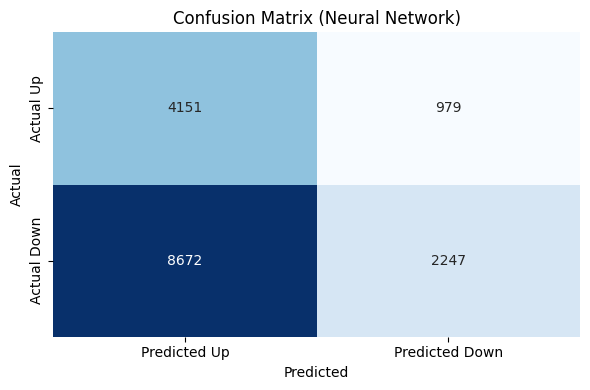

Summary of Results:
GMM - Accuracy: 0.4519, F1-Score: 0.4591
KNN - Accuracy: 0.6792, F1-Score: 0.8084
Neural Network - Accuracy: 0.3987, F1-Score: 0.3177


In [ ]:
# Visualize Confusion Matrix for Neural Network
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Up', 'Predicted Down'],
            yticklabels=['Actual Up', 'Actual Down'])
plt.title("Confusion Matrix (Neural Network)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('confusion_matrix_nasdaq_nn.png')
plt.show()

# Summary of Results
print("Summary of Results:")
print(f"GMM - Accuracy: {accuracy_gmm:.4f}, F1-Score: {f1_gmm:.4f}")
print(f"KNN - Accuracy: {accuracy_knn:.4f}, F1-Score: {f1_knn:.4f}")
print(f"Neural Network - Accuracy: {accuracy_nn:.4f}, F1-Score: {f1_nn:.4f}")